## Классификация отзывов клиентов банка на позитивные/негативные

#### импортируем библиотеки и загружаем данные

In [1]:
import pandas as pd
import numpy as np

# natural language toolkit 
import nltk

# regular expression
import re
import string

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer


from tqdm import tqdm

In [2]:
path = 'train_tin.csv'
df = pd.read_csv(path, encoding='cp1251')
df.shape

(3950, 2)

In [5]:
#тип колонок и количство nan
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3950 entries, 0 to 3949
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   text        3950 non-null   object
 1   isPositive  3950 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 61.8+ KB


In [6]:
df.head()

,text,isPositive
0,"27.09.19 через сайт в разделе ""Рефинансировани...",0
1,Добрый день! Неоднократно поступают звонки по ...,0
2,В первый раз решила воспользоваться кредитной ...,0
3,На самом дело уже накипело из-за участившегося...,0
4,Если вы дорожите своими нервами - ни при каких...,0


In [7]:
#добавили новые признаки
df['number_words'] = df['text'].transform(lambda x: len(x.split()))

In [8]:
df.iloc[4, 0]

'Если вы дорожите своими нервами - ни при каких обстоятельствах не имейте дел с кредитными продуктами этого банка!В Тинькофф-банке у меня была оформлена кредитная карта и потребительский кредит. Кредит я оформила в августе, по графику платежей я\xa0должна была вносить по нему 4820 руб. 7-го числа каждого месяца, начиная с\xa0сентября.Кредитной картой год не пользовалась вообще, в июле этого года сняла с нее 20 000 тыс. 1 августа полностью погасила всю сумму\xa0задолженности, которую на тот момент видела в своем интернет-банке\xa0(долг+проценты) и была полностью уверена, что по кредитке я больше ничего не\xa0должна.\xa026 сентября мне поступает первое за все время смс-сообщение банка, что у меня просрочен платеж по кредитной карте на сумму 143 руб. и будет\xa0начислен штраф. Я ни разу в жизни не допускала просрочек по кредитам, и,\xa0конечно, была в шоке. Звоню в банк и выясняю, что уже после внесения мной\xa0платежа проценты по кредитке были доначислены.\xa0Никаких оповещений я об\xa0э

In [9]:
#баланс классов
df['isPositive'].value_counts()

0    1975
1    1975
Name: isPositive, dtype: int64

<AxesSubplot:>

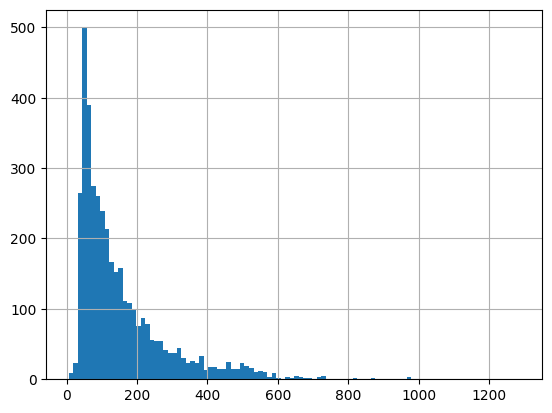

In [10]:
#количество слов
df['number_words'].hist(bins=100)

In [11]:
df.describe().round().T

,count,mean,std,min,25%,50%,75%,max
isPositive,3950.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
number_words,3950.0,156.0,136.0,6.0,63.0,110.0,198.0,1287.0


In [12]:
!pip install pymorphy2
import pymorphy2

In [13]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer  
from nltk.tokenize import RegexpTokenizer

In [14]:
def clean(text):
    text = text.lower() #нижний регистр
    text = re.sub('<.*?>', '', text) # Remove HTML from text
    text = re.sub('\xa0', ' ', text)
    text = text.translate(str.maketrans('', '', string.punctuation)) # удаляем знаки препинания
    text = re.sub(r'\d+', ' ', text) # удаляем числа
    
    return text

In [15]:
clean(df.iloc[4, 0])

'если вы дорожите своими нервами  ни при каких обстоятельствах не имейте дел с кредитными продуктами этого банкав тинькоффбанке у меня была оформлена кредитная карта и потребительский кредит кредит я оформила в августе по графику платежей я должна была вносить по нему   руб  го числа каждого месяца начиная с сентябрякредитной картой год не пользовалась вообще в июле этого года сняла с нее     тыс   августа полностью погасила всю сумму задолженности которую на тот момент видела в своем интернетбанке долгпроценты и была полностью уверена что по кредитке я больше ничего не должна   сентября мне поступает первое за все время смссообщение банка что у меня просрочен платеж по кредитной карте на сумму   руб и будет начислен штраф я ни разу в жизни не допускала просрочек по кредитам и конечно была в шоке звоню в банк и выясняю что уже после внесения мной платежа проценты по кредитке были доначислены никаких оповещений я об этом не получала  равно как и никаких предварительных напоминаний о нео

In [16]:
text = df.iloc[:, 0]

In [17]:
# Начинаем делать предварительную обработку текста

text = text.apply(clean)
text.head(15)

0       через сайт в разделе рефинансирование сторон...
1     добрый день неоднократно поступают звонки по д...
2     в первый раз решила воспользоваться кредитной ...
3     на самом дело уже накипело изза участившегося ...
4     если вы дорожите своими нервами  ни при каких ...
5     банк знаю давно очень и мне он не нравиться но...
6     тинькофф всегда нравился ваш банк но последний...
7       сентября   года после принудительного снятия...
8     несколько месяцев не могут убрать рекламу из м...
9     являюсь клиентом банка тинькофф по дебетовым п...
10    заблокировали карту когда находился за границе...
11    на столько заврались сначала говорят одну инфо...
12    была кредитка  платил уезжая на вахту положил ...
13    я являюсь клиентом ткс банка более   лет в осн...
14      я хотел оплатил долговую квитанцию по жкх че...
Name: text, dtype: object

In [18]:
# create lemmatizer object

pymorph = pymorphy2.MorphAnalyzer()

In [19]:
pymorph.parse(text[0].split()[3])[0].normal_form

'раздел'

In [20]:
# Применяем лемматизацию ко всем отзывам

lemmatized_text = []
for review in text:
    lemmatized_text.append(' '.join([pymorph.parse(word)[0].normal_form for word in review.split()]))

In [21]:
# Применяем токенизацию

reg_tokenizer = RegexpTokenizer('\w+')

In [22]:
tokenized_text = reg_tokenizer.tokenize_sents(lemmatized_text)

In [23]:
sw = stopwords.words('russian')

In [24]:
# удаляем стоп-слова
clean_tokenized_text = [] 

for i, review in tqdm(enumerate(tokenized_text), total=len(tokenized_text)):
    clean_tokenized_text.append(' '.join([word for word in review if word not in sw]))

100%|█████████████████████████████████████| 3950/3950 [00:00<00:00, 4703.18it/s]


In [25]:
len(clean_tokenized_text[0]), len(lemmatized_text[0])

(2361, 2870)

In [26]:
clean_tokenized_text[2]

'первый решить воспользоваться кредитный карта тинькофф банк карта лежать дом активировать сентябрь сделать покупка примерно посчитать льготный период день выходить начало ноябрь однако сегодня зайти мобильный приложение увидеть называть льготный период истекать октябрь это пол месяц маленький рассчитывать позвонить горячий линия пояснить выписка формироваться число каждый месяц формироваться число карта активный пользоваться её получение ваш сотрудник пояснить период начинать идти момент первый покупка активировать карта мошенник вводить заблуждение человек обманывать вычесть деньга страховка смс информирование хотя услуга выдача карта упоминаться это предупреждать также получить смс списание пополнение счёт получаться содрать деньга вернуть обратно счёт либо писать далёкий всё возможный инстанция вводить человек заблуждение простой говорить ваш банк мошенник ужасный банк человек вестись кредит карта тп ужасный обслуживание информирование дурить человек полный программа'

In [28]:
df = pd.concat([pd.Series(clean_tokenized_text, name='text'), 
                pd.Series(df['isPositive'], name='sentiment')], 
               axis=1)
df.head()

,text,sentiment
0,сайт раздел рефинансирование сторонний кредит ...,0
1,добрый день неоднократно поступать звонок долж...,0
2,первый решить воспользоваться кредитный карта ...,0
3,дело накипеть изз участиться намахалов сторона...,0
4,дорожить свой нерв обстоятельство иметь дело к...,0


#### Построим векторное представление слов и обучим модели

In [29]:
# import classifiers

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from catboost import CatBoostClassifier

from sklearn.model_selection import cross_val_score
from sklearn.decomposition import TruncatedSVD

In [30]:
# Создаем объекты для векторного представления Bag-of-Words, tf-idf
cvec = CountVectorizer(ngram_range=(1, 1))
tfid = TfidfVectorizer(ngram_range=(1, 1))

tsvd = TruncatedSVD(100)

In [31]:
rf = RandomForestClassifier(20)
lrc = LogisticRegression(max_iter=10000)
multinb = MultinomialNB()
catb = CatBoostClassifier(verbose=0)

In [32]:
clfs = {
    'RandomForest' : rf ,
    'LogisticRegression' : lrc,
    'MultinominalNaiveBayes': multinb,
    'CatBoostClassifier': catb
}

In [33]:
#Функция сравнивающая модели и способы векторизации текста

def get_scores(clfs, x, y, n_cv=3):
    results={}
    
    cvec_representation = cvec.fit_transform(x)
    tfid_representation = tfid.fit_transform(x)
    red_tf = tsvd.fit_transform(tfid_representation)
    
    for clf in tqdm(clfs):
        if clf == 'MultinominalNaiveBayes':
            tsvd_scores = cross_val_score(clfs[clf], red_tf + np.abs(np.min(red_tf)) + 1,  y, n_jobs=4, cv=n_cv, scoring='accuracy')
        else:
            tsvd_scores = cross_val_score(clfs[clf], red_tf,  y, n_jobs=4, cv=n_cv, scoring='accuracy')

            
        cvec_scores = cross_val_score(clfs[clf], cvec_representation, y, n_jobs=-1, cv=n_cv, scoring='accuracy')
        tfidf_scores = cross_val_score(clfs[clf], tfid_representation,  y, n_jobs=-1, cv=n_cv, scoring='accuracy')
        
        cvec_mean_score, cvec_std_score = np.mean(cvec_scores), np.std(cvec_scores)
        tfidf_mean_score, tfidf_std_score = np.mean(tfidf_scores), np.std(tfidf_scores)
        tsvd_mean_score, tsvd_std_score = np.mean(tsvd_scores), np.std(tsvd_scores)
        
        results.update({clf : [cvec_mean_score,  
                               tfidf_mean_score,
                               tsvd_mean_score]})
    
    return results
        

In [34]:
results = pd.DataFrame(get_scores(clfs, df['text'], df['sentiment'], 2), index=['BagOfWords', 'TfIdf', 'SVD']).T.reset_index()

100%|█████████████████████████████████████████████| 4/4 [03:25<00:00, 51.32s/it]


In [35]:
results

,index,BagOfWords,TfIdf,SVD
0,RandomForest,0.869620,0.874937,0.876962
1,LogisticRegression,0.922278,0.928608,0.926582
2,MultinominalNaiveBayes,0.926835,0.910886,0.895949
3,CatBoostClassifier,0.920253,0.912152,0.921013


Заметим, что лучше всего справилась модель логистической регрессии на векторизации tf-idf

In [36]:
lr = LogisticRegression(max_iter=10000)

tfid = TfidfVectorizer(ngram_range=(1, 1))
tfid_representation = tfid.fit_transform(df['text'])

lr.fit(tfid_representation, df['sentiment'])

LogisticRegression(max_iter=10000)

#### Загрузим тестовые данные

In [37]:
path = 'test_tin.csv'
df_test = pd.read_csv(path, encoding='cp1251')
df_test.shape

(1000, 2)

In [38]:
df_test.head()

,text,isPositive
0,Добрый день! Я являюсь клиентом Тинькофф банк ...,NaN
1,Хочу выразить огромную благодарность банку Тин...,NaN
2,Выражаю благодарность К-ву Александру В. за ст...,NaN
3,В январе 2019 года оформила потребительский кр...,NaN
4,Добрый день. Хочу поблагодарить банк Тинькофф ...,NaN


In [39]:
text_test = df_test.iloc[:, 0]

In [40]:
# Начинаем делать предварительную обработку текста

text_test = text_test.apply(clean)

In [41]:
# Применяем лемматизацию ко всем отзывам
pymorph = pymorphy2.MorphAnalyzer()

lemmatized_text = []
for review in text_test:
    lemmatized_text.append(' '.join([pymorph.parse(word)[0].normal_form for word in review.split()]))

In [42]:
# Применяем токенизацию

reg_tokenizer = RegexpTokenizer('\w+')
tokenized_text = reg_tokenizer.tokenize_sents(lemmatized_text)

# удаляем стоп-слова

clean_tokenized_text = [] 

for i, review in tqdm(enumerate(tokenized_text), total=len(tokenized_text)):
    clean_tokenized_text.append(' '.join([word for word in review if word not in sw]))

100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 4740.43it/s]


In [43]:
tfidf_representation_test = tfid.transform(clean_tokenized_text)

prediction = lr.predict(tfidf_representation_test)

In [44]:
df_test.iloc[:, 1] = prediction

In [45]:
df_test.head()

,text,isPositive
0,Добрый день! Я являюсь клиентом Тинькофф банк ...,0
1,Хочу выразить огромную благодарность банку Тин...,1
2,Выражаю благодарность К-ву Александру В. за ст...,1
3,В январе 2019 года оформила потребительский кр...,0
4,Добрый день. Хочу поблагодарить банк Тинькофф ...,1
